---



# <font color='#ECA702'>**Análisis Multimodal de Síntomas en la Enfermedad de Parkinson**</font>

# **Contenido**

[**0. Comprendiendo el problema a tratar**](#tema1)

[**1. Exploración de datos**](#tema2)

&emsp;&emsp;[**1.1. Visualización**](#tema3)

&emsp;&emsp;[**1.2. Análisis**](#tema4)

&emsp;&emsp;&emsp;&emsp;&emsp; [**1.2.1 Disartria**](#tema5)

&emsp;&emsp;&emsp;&emsp;&emsp; [**1.2.2 Hipomimia**](#tema6)

[**2. Extracción de características**](#tema7)

&emsp;&emsp;[**2.1 Disartria**](#tema8)

&emsp;&emsp;[**2.2. Hipomimia**](#tema9)



&emsp;&emsp;[**2.3 Disparidad**](#tema15)

&emsp;&emsp;[**2.4 Profundidad**](#tema16)

&emsp;&emsp;[**2.5 PointCloud -3D**](#tema17)

[**3. Modelos**](#tema8)

In [ ]:
#@title **Instalar paquetes**
# ! pip install remotezip tqdm opencv-python
# ! pip install -q git+https://github.com/tensorflow/docs
# ! pip install gdown

In [8]:
#@title **Importar librerías**

# Manipulación de datos
import os
import cv2
import numpy as np
import librosa
import pandas as pd

# Utils
from tqdm import tqdm
import IPython.display as ipd # Nos permite reproducir audios
import matplotlib.pyplot as plt
from ipywidgets import widgets, IntSlider, interactive # Nos permite visualizar frames de vídeos

# <font color='#4C5FDA'> **1. ¡Exploremos nuestros datos! 😎**</color> <a name="tema2">


In [2]:
#@title **Cargamos los datos desde Drive**

from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/data_parkinson')
print(os.getcwd())

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1XRruCPRodR4OhRCRZYKsyODqa_GuBkfC/data_parkinson


## <font color='#EB9A54'>**1.1 Creación del DataFrame**</font> <a name = "tema3">

In [10]:
#@title **DataFrame con todos los registros**

# Directorio principal
main_directory = "AudioVisualData_v7"

patients = []
labels = []
frames = []
audios = []

"""
Esta construcción del dataset depende de la estructura del mismo
"""

# Itero por cada tipo de paciente: Control, Parkinson
for patient_type in os.listdir(main_directory):

  # A la ruta del directorio le concateno el tipo de paciente
  patient_type_path = os.path.join(f"{main_directory}/{patient_type}")

  # Itero por cada paciente en cada tipo de paciente
  for patient in os.listdir(patient_type_path):

    # A la ruta del tipo de paciente le concateno el paciente
    audio_type_path = os.path.join(f"{patient_type_path}/{patient}")

    # Itero por el tipo de sample: Phonemes, Vowels, Words
    for sample_type in os.listdir(audio_type_path):

      # Armo la ruta hasta el tipo de sample
      file_type_path = os.path.join(f"{audio_type_path}/{sample_type}")

      # Itero por cada registro en cada tipo de sample y le anaño audio a la ruta
      # para que entre de una vez a los registros
      for record in os.listdir(f"{file_type_path}/audio"):

        # Armo la ruta hasta el registro
        record_path = os.path.join(f"{file_type_path}/audio/{record}")
        # Agrego el paciente a la lista de pacientes
        patients.append(patient)
        # Agrego el label al final para asegurar que lo haga para cada paciente
        if patient_type == 'Parkinson':
          labels.append(1.)
        else:
          labels.append(0.)
        # Agrego la ruta del video
        frames.append(record_path.replace('audio', 'frames').replace('.mp3', '.mov'))
        # Agrego la ruta del audio
        audios.append(record_path)

# Crear un DataFrame con la información
data = pd.DataFrame({
    'patient': patients,
    'audio_path': audios,
    'frames_path': frames,
    'label': labels
})

data.set_index('patient', inplace=True)
data.head()

,audio_path,frames_path,label
patient,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0


In [11]:
#@title **Función para obtener una muestra**

def get_sample(tipo:float):

  sample = data[(data['label']==tipo)].sample(1)

  if tipo == 1.0:
    tipo = 'Parkinson'
  else:
    tipo = 'Control'
  sample = [sample['audio_path'].item(), sample['frames_path'].item(), tipo]
  return sample

## <font color='#EB9A54'>**1.2 Visualización de los datos**</font> <a name = "tema3">

In [12]:
parkinson = get_sample(1.0)
control = get_sample(0.0)

### <font color='#52F17F'>**Hipomimia (vídeos)**</font>

In [10]:
def funcion(x, video_path: str):
    img = cv2.imread(f"{video_path}/"+"0"*(6-len(str(x)))+str(x)+".jpg")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(video_path.split('/')[-1])
    plt.show()

In [11]:
#@title Muestra con hipomimia
slow = interactive(funcion, video_path=parkinson[1],x=widgets.IntSlider(min=1, max=100, step=1), continuous_update=True)
slow

interactive(children=(IntSlider(value=1, description='x', min=1), Text(value='AudioVisualData_v7/Parkinson/P7/…

In [12]:
#@title Muestra sin hipomimia
slow = interactive(funcion, video_path=control[1],x=widgets.IntSlider(min=1, max=100, step=1), continuous_update=True)
slow

interactive(children=(IntSlider(value=1, description='x', min=1), Text(value='AudioVisualData_v7/Control/C2/Wo…

### <font color='#52F17F'>**Disartria (audios)**</font>

In [ ]:
#@title Muestra con disartria
ipd.Audio(parkinson[0])

In [ ]:
#@title Muestra sin disartria
ipd.Audio(control[0])

#  <font color='#4C5FDA'> **2. Preprocesamiento de los datos 🧐**</color> <a name="tema7">


## <a name = "tema8"><font color='#EB9A54'>**2.1 Extracción de caracterísitcas para la disartria**</font> </a>

El espectrograma Mel mapea frecuencias a una escala perceptualmente lineal, reflejando mejor la respuesta auditiva humana y destacando características relevantes para el reconocimiento de sonido, por esto, decidimos usarlo.

Este espectograma es una escala logarítmica basada en el principio de que distancias iguales en la escala tienen la misma distancia perceptiva.

<center>
  <img src="https://www.researchgate.net/publication/351469852/figure/fig1/AS:1022100571705347@1620699174717/The-process-of-extracting-the-Mel-spectrogram-from-an-acoustic-signal-where-the-output.png" width="600" height="400">
</center>

La conversión de frecuencia (f) a escala Mel (m) viene dada por: $m = 2595*log(1+\frac{f}{500})$

Un [espectrograma Mel](https://devopedia.org/audio-feature-extraction) es, por tanto, un espectrograma en el que las frecuencias se convierten a la escala Mel.

Por suerte, [librosa](https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html) tiene la implementación del pipeline para conseguir los espectogramas MEL en una línea. Específicamente `librosa.feature.melspectrogram(y=x, sr=sr)` calcula un espectrograma a escala mel.

### <font color="52F17F">**Cantidad promedio de segundos por audio**</font>

In [ ]:
def get_mean_audio_duration(df):
    times = []

    for i, record in tqdm(df.iterrows(), total=df.shape[0]):
        try:
            x, sr = librosa.load(record['audio_path'], sr=48000)
            time = librosa.get_duration(y=x, sr=sr)
            times.append(time)

        except EOFError:
            print(f'Error reading audio: {i}')
            pass

    return sum(times) / len(times)

In [ ]:
# Saco la media de duración de todos los aduios
SEGUNDOS_PROMEDIO = get_mean_audio_duration(data)

100%|██████████| 1091/1091 [00:04<00:00, 227.26it/s]


In [ ]:
print(f"{SEGUNDOS_PROMEDIO*0.1:.6f}")

0.239328


### <font color="52F17F">**Ejemplo con un sample y función de preprocesamiento**</font>

In [13]:
"""
Constante sacada de la media de duración de todos los audios multiplicada por 0.1
para tener el 10%
"""
SEGUNDOS_PROMEDIO = 0.239328

In [14]:
def preprocess_audio(audio:str):
  """
  Esta función calcula el espectograma mel en escala logarítmica de un audio
  con pasos de 25ms y una ventana de 40ms. Además usamos 90 bandas mel y un
  sampling rate de 48 kHz.

  Args:
    audio: path del audio
  Returns:
    log_mel_spectogram: An array of mel spectogram in the shape of (n_mels, n_frames).
  """
  samples, sample_rate = librosa.load(audio, sr = 48000, duration=SEGUNDOS_PROMEDIO)
  steps = int(25/(1/sample_rate*1000)) # Pasos de 25ms
  window = int(40/(1/sample_rate*1000)) # window (numero de samples por ventana) de 40ms

  # Encontramos el espectograma mel con 90 bandas.
  mel_spectogram = librosa.feature.melspectrogram(y=samples, sr=sample_rate, n_fft = window, hop_length=steps, n_mels = 90)

  # Lo movemos a escala logarítmica
  log_mel_spectogram = librosa.power_to_db(mel_spectogram)
  return log_mel_spectogram.flatten()

In [15]:
sample_preprocessed_audio = preprocess_audio(get_sample(1.0)[0])

In [16]:
sample_preprocessed_audio.shape

(900,)

In [17]:
print(f"Un sample equivale a {1/48000*1000:.4f}ms")

Un sample equivale a 0.0208ms


In [18]:
print(f"Un frame (usando ventanas de 40ms) tiene {40/(1/48000*1000)} samples")

Un frame (usando ventanas de 40ms) tiene 1920.0 samples


In [19]:
print(f"Usamos {sample_preprocessed_audio.shape[0]/90} audio frames/columnas por muestra")

Usamos 10.0 audio frames/columnas por muestra


### <font color="52F17F">**Aplicar el preprocesamiento a todos los audios**</font>

In [20]:
# Preprocesar todos los audios y almacenar los espectrogramas mel
data['flatten_log_mel_spectogram'] = data['audio_path'].apply(preprocess_audio)

# Verificar los datos
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram
patient,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.666367, -19.71575, -24.277515, -19.924854..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838, -28.27943, -28.845644, -30.651566, ..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.0914, -25.001015, -28.57779, -24.155487, ..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915, -20.14505, -20.716843, -20.637115..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82709, -20.313282, -26.990557, -23.019135..."


In [21]:
data['flatten_log_mel_spectogram'][0].shape

(900,)

## <font color='#EB9A54'>**2.2 Extracción de caracterísitcas para la hipomimia**</font> <a name = "tema8">

### <font color="52F17F">**Cantidad promedio de frames por vídeo**</font>

In [ ]:
def get_mean_video_duration(df):
    frames = []

    for i, record in tqdm(df.iterrows(), total=df.shape[0]):
        try:
            n_frames = len(os.listdir(record['frames_path']))
            frames.append(n_frames)

        except EOFError:
            print(f'Error reading video: {i}')
            pass

    return sum(frames) / len(frames)

In [ ]:
FRAMES_PROMEDIO = get_mean_video_duration(data)

100%|██████████| 1091/1091 [00:00<00:00, 5827.90it/s]


In [ ]:
print(f"{FRAMES_PROMEDIO*0.1:.0f}")

14


### <font color="52F17F">**Ejemplo con un sample y función de preprocesamiento**</font>

In [ ]:
"""
Constante sacada de la media de cantidad de frames de todos los vídeos multiplicada por 0.1
para tener el 10%
"""

FRAMES_PROMEDIO = 14

In [ ]:
def preprocess_frame(frame_path: str):
  frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE) # Leemos la imagen desde la ruta en escala de grises
  # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # La pasamos de BGR a RGB
  frame = cv2.resize(frame, (112, 112)) # Resize a 112x112
  frame = frame / 255. # Normalizamos entre 0 y 1
  return frame.flatten()
  # return frame

Cuando aplicamos concatenate(), todos los valores de los píxeles de los frames se concatenan en una única secuencia lineal. El orden es: primero todos los valores del primer frame, seguidos por todos los valores del segundo frame, y así sucesivamente.

In [ ]:
def preprocess_video(video_path: str, n_frames = FRAMES_PROMEDIO):
  frames = []
  for frame in sorted(os.listdir(video_path))[:n_frames]:
    frames.append(preprocess_frame(f"{video_path}/{frame}"))
  return np.concatenate(frames)
  # return frames

In [ ]:
sample_preprocessed_video = get_sample(1.0)[1] # Obtengo la ruta de un vídeo
sample_preprocessed_video = preprocess_video(sample_preprocessed_video) # Aplico la función de preprocesamiento

In [ ]:
sample_preprocessed_video.shape #14×112×112×1=175616

(175616,)

### <font color="52F17F">**Aplicar el preprocesamiento a todos los vídeos**</font>

In [ ]:
# Preprocesar todos los audios y almacenar los espectrogramas mel
data['flatten_frame_sequence'] = data['frames_path'].apply(preprocess_video)

# Verificar los datos
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram,flatten_frame_sequence
patient,,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.666367, -19.71575, -24.277515, -19.924854...","[0.44313725490196076, 0.4470588235294118, 0.44..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838, -28.27943, -28.845644, -30.651566, ...","[0.4627450980392157, 0.4627450980392157, 0.458..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.0914, -25.001015, -28.57779, -24.155487, ...","[0.4666666666666667, 0.4666666666666667, 0.474..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915, -20.14505, -20.716843, -20.637115...","[0.44313725490196076, 0.44313725490196076, 0.4..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82709, -20.313282, -26.990557, -23.019135...","[0.4627450980392157, 0.45098039215686275, 0.45..."


In [ ]:
data['flatten_frame_sequence'][0].shape

## <font color='#EB9A54'>**2.3 Fusión de caracterísitcas**</font> <a name = "tema8">

### <font color="52F17F">**Ejemplo con un sample y función de preprocesamiento**</font>

In [ ]:
def preprocess_and_fuse(flatten_frame_sequence, flatten_log_mel_spectogram):
    """
    Esta función concatena los frames aplanados y el espectrograma mel aplanado.

    Args:
        flatten_frame_sequence: array de frames aplanados.
        flatten_log_mel_spectogram: array de espectrograma mel aplanado.

    Returns:
        fused_features: Un array que contiene la concatenación de los frames y el espectrograma mel.
    """
    # Concatenar los frames y el espectrograma mel
    return np.concatenate([flatten_frame_sequence, flatten_log_mel_spectogram])

In [ ]:
random_idx = np.random.choice(range(1, len(data)))
sample_fusioned = data[['flatten_frame_sequence', 'flatten_log_mel_spectogram']].iloc[random_idx].values

In [ ]:
sample_fusioned.shape

(2,)

In [ ]:
sample_fusioned = preprocess_and_fuse(sample_fusioned[0], sample_fusioned[1])

In [ ]:
sample_fusioned.shape # Debería ser (14 * 112 * 112 + 900,)

(176516,)

### <font color="52F17F">**Aplicar la fusión a todos los registros**</font>

In [ ]:
# Fusionar todas las características aplanadas
data['fused_flattened_features'] = data.apply(
    lambda row: preprocess_and_fuse(row['flatten_frame_sequence'], row['flatten_log_mel_spectogram']),
    axis=1
)

# Verificar los datos
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram,flatten_frame_sequence,fused_flattened_features
patient,,,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.666367, -19.71575, -24.277515, -19.924854...","[0.44313725490196076, 0.4470588235294118, 0.44...","[0.44313725490196076, 0.4470588235294118, 0.44..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838, -28.27943, -28.845644, -30.651566, ...","[0.4627450980392157, 0.4627450980392157, 0.458...","[0.4627450980392157, 0.4627450980392157, 0.458..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.0914, -25.001015, -28.57779, -24.155487, ...","[0.4666666666666667, 0.4666666666666667, 0.474...","[0.4666666666666667, 0.4666666666666667, 0.474..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915, -20.14505, -20.716843, -20.637115...","[0.44313725490196076, 0.44313725490196076, 0.4...","[0.44313725490196076, 0.44313725490196076, 0.4..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82709, -20.313282, -26.990557, -23.019135...","[0.4627450980392157, 0.45098039215686275, 0.45...","[0.4627450980392157, 0.45098039215686275, 0.45..."


In [ ]:
data['fused_flattened_features'][0].shape

(176516,)

# <font color='#4C5FDA'> **3. State-of-the-art ML 🦾**</color> <a name="tema8">

In [ ]:
# Sklearn for datasets.
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold

# Sklearn metrics.
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score)

# Sklearn models
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
models = [
    ('GNB', GaussianNB()),
    ('DT DEFAULT', DecisionTreeClassifier()),
    ('DT2', DecisionTreeClassifier(max_depth=2)),
    ('DT40', DecisionTreeClassifier(max_depth=40)),
    ('RF50', RandomForestClassifier(n_estimators=50)),
    ('RF100', RandomForestClassifier(n_estimators=100)),
    ('RF200', RandomForestClassifier(n_estimators=200)),
    ('SVM LINEAR', SVC(kernel='linear')),
    ('SVM RBF', SVC(kernel='rbf')),
    ('SVM POLY DEGREE 3', SVC(kernel='poly')),
    ('LR', LogisticRegression(max_iter=2000)),
]

<font color="52F17F">**Escalando las características con sklearn Standard Scaler**</font>

Con esto conseguimos [estandarizar](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) las características eliminando la media (es decir, $\mu = 0$) y escalando a la varianza unitaria (es decir $\sigma = 1$).

<center>
  <img src="https://imgs.search.brave.com/6nO8SCp_NlJdLQRnJRJDgmmNWZjgzK-BvBoRgq6HZfw/rs:fit:860:0:0/g:ce/aHR0cHM6Ly9taXJv/Lm1lZGl1bS5jb20v/bWF4LzE0MDAvMSpH/QWNFajM3c21DT0Na/TXJxcC1yampBLnBu/Zw" width="600" height="400">
</center>

The fit(data) method is used to compute the mean and std dev for a given feature to be used further for scaling. The transform(data) method is used to perform scaling using mean and std dev calculated using the . fit() method. The fit_transform() method does both fits and transform.

<font color="52F17F">**Partición de los datos**</font>

Dado que tenemos 14 pacientes, si hacemos 5 divisiones, cada división intentará mantener aproximadamente el mismo número de pacientes en cada conjunto. Cada división entrena con 11 pacientes y prueba con 3 pacientes. Esto asegura que los datos de un mismo paciente no se mezclen entre los conjuntos de entrenamiento y prueba. [Fuente](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators-for-grouped-data).


In [ ]:
# Crear el objeto GroupKFold
group_kfold = GroupKFold(n_splits=5)
X = np.ones((1091, 1))
y = np.ones((1091, 1))

groups = data.index.values

# Realizar la validación cruzada por grupos
for i, (train_index, test_index) in enumerate(group_kfold.split(X, y, groups), 1):
    # X_train, X_test = X[train_index], X[test_index]
    # y_train, y_test = y[train_index], y[test_index]
    train_groups = groups[train_index]
    test_groups = groups[test_index]

    print(f"División {i}:")
    print("  Pacientes en entrenamiento:", np.unique(train_groups))
    print("  Pacientes en prueba:", np.unique(test_groups))
    print("  Número de pacientes en entrenamiento:", len(np.unique(train_groups)))
    print("  Número de pacientes en prueba:", len(np.unique(test_groups)))
    print()

División 1:
  Pacientes en entrenamiento: ['C0' 'C1' 'C3' 'C4' 'C5' 'C6' 'P0' 'P4' 'P5' 'P6' 'P7']
  Pacientes en prueba: ['C2' 'P1' 'P8']
  Número de pacientes en entrenamiento: 11
  Número de pacientes en prueba: 3

División 2:
  Pacientes en entrenamiento: ['C0' 'C2' 'C3' 'C4' 'C5' 'P0' 'P1' 'P4' 'P5' 'P6' 'P8']
  Pacientes en prueba: ['C1' 'C6' 'P7']
  Número de pacientes en entrenamiento: 11
  Número de pacientes en prueba: 3

División 3:
  Pacientes en entrenamiento: ['C1' 'C2' 'C3' 'C4' 'C6' 'P0' 'P1' 'P4' 'P5' 'P7' 'P8']
  Pacientes en prueba: ['C0' 'C5' 'P6']
  Número de pacientes en entrenamiento: 11
  Número de pacientes en prueba: 3

División 4:
  Pacientes en entrenamiento: ['C0' 'C1' 'C2' 'C3' 'C5' 'C6' 'P1' 'P4' 'P6' 'P7' 'P8']
  Pacientes en prueba: ['C4' 'P0' 'P5']
  Número de pacientes en entrenamiento: 11
  Número de pacientes en prueba: 3

División 5:
  Pacientes en entrenamiento: ['C0' 'C1' 'C2' 'C4' 'C5' 'C6' 'P0' 'P1' 'P5' 'P6' 'P7' 'P8']
  Pacientes en prueba: [

<font color="52F17F">**Métricas de evaluación**</font>

En el caso del Parkinson, es más importante saber cuándo mi modelo identifica correctamente a una persona con Parkinson (True Positive), ya que si mi modelo indica que no tiene Parkinson y en realidad sí lo tiene (False Negative), se afecta significativamente su calidad de vida.

<center>
  <img src="https://www.tutorialexample.com/wp-content/uploads/2022/01/how-to-compute-accuracy-precision-recall-and-f1-score-in-machine-learning.png" width="600" height="400">
</center>

Por ende, la métrica que nos interesa es el <font color= "52F17F"> **recall.** </font>




## <font color='#EB9A54'>**3.1 Solo audio features**</font> <a name = "tema10">

In [ ]:
X = np.array(data['flatten_log_mel_spectogram'].tolist())
y = np.array(data['label'].tolist())

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Inicializar un diccionario para almacenar las métricas de evaluación
results = {name: {'accuracy': [], 'f1': [], 'precision': [], 'sensitivity': []} for name, _ in models}

# Crear el objeto GroupKFold
group_kfold = GroupKFold(n_splits=5)

groups = data.index.values

# Realizar la validación cruzada por grupos
for (train_index, test_index) in group_kfold.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    train_groups = groups[train_index]
    test_groups = groups[test_index]

    # Entrenar y evaluar cada modelo
    for name, model in models:
        clf = model
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        sensitivity = recall_score(y_test, y_pred)

        results[name]['accuracy'].append(accuracy)
        results[name]['f1'].append(f1)
        results[name]['precision'].append(precision)
        results[name]['sensitivity'].append(sensitivity)

In [ ]:
# Calcular las métricas promedio para cada modelo
avg_results = {name: {metric: np.mean(scores) for metric, scores in metrics.items()} for name, metrics in results.items()}

# Mostrar resultados promedio
for name, metrics in avg_results.items():
    print(f"{11*'='} Resultados para {name} {11*'='}")
    for metric, score in metrics.items():
        print(f"  {metric}: {score:.4f}")
    print()

=========== Resultados para GNB ===========
  accuracy: 0.4919
  f1: 0.4626
  precision: 0.4945
  sensitivity: 0.5108

=========== Resultados para DT DEFAULT ===========
  accuracy: 0.5384
  f1: 0.5235
  precision: 0.5349
  sensitivity: 0.5491

=========== Resultados para DT2 ===========
  accuracy: 0.5396
  f1: 0.4179
  precision: 0.6001
  sensitivity: 0.3796

=========== Resultados para DT40 ===========
  accuracy: 0.5512
  f1: 0.5383
  precision: 0.5449
  sensitivity: 0.5621

=========== Resultados para RF50 ===========
  accuracy: 0.4896
  f1: 0.4445
  precision: 0.4778
  sensitivity: 0.4771

=========== Resultados para RF100 ===========
  accuracy: 0.4879
  f1: 0.4213
  precision: 0.4667
  sensitivity: 0.4464

=========== Resultados para RF200 ===========
  accuracy: 0.5045
  f1: 0.4426
  precision: 0.4851
  sensitivity: 0.4682

=========== Resultados para SVM LINEAR ===========
  accuracy: 0.4849
  f1: 0.4614
  precision: 0.4856
  sensitivity: 0.4760

=========== Resultados para 

## <font color='#EB9A54'>**3.2 Solo video features**</font> <a name = "tema9">

In [ ]:
X = np.array(data['flatten_frame_secuence'].tolist())
y = np.array(data['label'].tolist())

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Inicializar un diccionario para almacenar las métricas de evaluación
results = {name: {'accuracy': [], 'f1': [], 'precision': [], 'sensitivity': []} for name, _ in models}

# Crear el objeto GroupKFold
group_kfold = GroupKFold(n_splits=5)

groups = data.index.values

# Realizar la validación cruzada por grupos
for (train_index, test_index) in group_kfold.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    train_groups = groups[train_index]
    test_groups = groups[test_index]

    # Entrenar y evaluar cada modelo
    for name, model in models:
        clf = model
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        sensitivity = recall_score(y_test, y_pred)

        results[name]['accuracy'].append(accuracy)
        results[name]['f1'].append(f1)
        results[name]['precision'].append(precision)
        results[name]['sensitivity'].append(sensitivity)

/home/guillermo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guillermo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Calcular las métricas promedio para cada modelo
avg_results = {name: {metric: np.mean(scores) for metric, scores in metrics.items()} for name, metrics in results.items()}

# Mostrar resultados promedio
for name, metrics in avg_results.items():
    print(f"{11*'='} Resultados para {name} {11*'='}")
    for metric, score in metrics.items():
        print(f"  {metric}: {score:.4f}")
    print()

=========== Resultados para GNB ===========
  accuracy: 0.5944
  f1: 0.5963
  precision: 0.6667
  sensitivity: 0.7500

=========== Resultados para DT DEFAULT ===========
  accuracy: 0.5410
  f1: 0.4653
  precision: 0.5481
  sensitivity: 0.4820

=========== Resultados para DT2 ===========
  accuracy: 0.5631
  f1: 0.5188
  precision: 0.5731
  sensitivity: 0.5962

=========== Resultados para DT40 ===========
  accuracy: 0.5499
  f1: 0.5117
  precision: 0.5903
  sensitivity: 0.5397

=========== Resultados para RF50 ===========
  accuracy: 0.5807
  f1: 0.4989
  precision: 0.6450
  sensitivity: 0.5716

=========== Resultados para RF100 ===========
  accuracy: 0.6004
  f1: 0.5276
  precision: 0.6393
  sensitivity: 0.6179

=========== Resultados para RF200 ===========
  accuracy: 0.5965
  f1: 0.5354
  precision: 0.6350
  sensitivity: 0.6204

=========== Resultados para SVM LINEAR ===========
  accuracy: 0.7962
  f1: 0.7611
  precision: 0.8837
  sensitivity: 0.7500

=========== Resultados para 

## <font color='#EB9A54'>**3.2 Fusion of features**</font> <a name = "tema9">

In [ ]:
X = np.array(data['fused_flattened_features'].tolist())
y = np.array(data['label'].tolist())

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Inicializar un diccionario para almacenar las métricas de evaluación
results = {name: {'accuracy': [], 'f1': [], 'precision': [], 'sensitivity': []} for name, _ in models}

# Crear el objeto GroupKFold
group_kfold = GroupKFold(n_splits=5)

groups = data.index.values

# Realizar la validación cruzada por grupos
for (train_index, test_index) in group_kfold.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    train_groups = groups[train_index]
    test_groups = groups[test_index]

    # Entrenar y evaluar cada modelo
    for name, model in models:
        clf = model
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        sensitivity = recall_score(y_test, y_pred)

        results[name]['accuracy'].append(accuracy)
        results[name]['f1'].append(f1)
        results[name]['precision'].append(precision)
        results[name]['sensitivity'].append(sensitivity)

/home/guillermo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guillermo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guillermo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Calcular las métricas promedio para cada modelo
avg_results = {name: {metric: np.mean(scores) for metric, scores in metrics.items()} for name, metrics in results.items()}

# Mostrar resultados promedio
for name, metrics in avg_results.items():
    print(f"{11*'='} Resultados para {name} {11*'='}")
    for metric, score in metrics.items():
        print(f"  {metric}: {score:.4f}")
    print()

=========== Resultados para GNB ===========
  accuracy: 0.5944
  f1: 0.5963
  precision: 0.6667
  sensitivity: 0.7500

=========== Resultados para DT DEFAULT ===========
  accuracy: 0.5413
  f1: 0.4689
  precision: 0.5463
  sensitivity: 0.5051

=========== Resultados para DT2 ===========
  accuracy: 0.5623
  f1: 0.5188
  precision: 0.5731
  sensitivity: 0.5962

=========== Resultados para DT40 ===========
  accuracy: 0.5789
  f1: 0.5814
  precision: 0.6242
  sensitivity: 0.6500

=========== Resultados para RF50 ===========
  accuracy: 0.5991
  f1: 0.5223
  precision: 0.6334
  sensitivity: 0.6128

=========== Resultados para RF100 ===========
  accuracy: 0.6038
  f1: 0.5429
  precision: 0.6427
  sensitivity: 0.6230

=========== Resultados para RF200 ===========
  accuracy: 0.5966
  f1: 0.5237
  precision: 0.6403
  sensitivity: 0.6128

=========== Resultados para SVM LINEAR ===========
  accuracy: 0.7970
  f1: 0.7622
  precision: 0.8874
  sensitivity: 0.7500

=========== Resultados para 

# <font color='#4C5FDA'> **4. State-of-the-art DL 🤖**</color> <a name="tema8">

In [ ]:
import keras
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.applications.efficientnet import EfficientNetB0, preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input

In [ ]:
# Asumiendo que 'data' es tu DataFrame y contiene los frames aplanados
def preprocess_frames(frames, target_size):
    # Convertir frames a su forma original y luego a RGB
    frames = np.reshape(frames, (14, 112, 112, 1))  # 14 frames de 112x112 en escala de grises
    frames_rgb = np.repeat(frames, 3, axis=-1)  # Convertir a RGB repitiendo los canales
    resized_frames = [array_to_img(frame).resize(target_size) for frame in frames_rgb]
    return np.array([img_to_array(frame) for frame in resized_frames])

# Crear una columna para los frames preprocesados
data['preprocessed_frames'] = data['flatten_frame_secuence'].apply(lambda x: preprocess_frames(x, (224, 224)))

: 

In [ ]:
# Creamos los modelos base para entrenarlos
mobile_model = MobileNetV2(include_top=False)
mobile_model.trainable = False
efficient_model = EfficientNetB0(include_top=False)
efficient_model.trainable = False
vgg16_model = VGG16(include_top=False)
vgg16_model.trainable = False

: 

In [ ]:
# add a global spatial average pooling layer

x = mobile_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = keras.layers.Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = keras.layers.Dense(200, activation='softmax')(x)

In [ ]:
# this is the model we will train
model = keras.models.Model(inputs=mobile_model.input, outputs=predictions)

# <font color='#4C5FDA'> **5.  Data Augmentation**</color> <a name="tema8">

# <font color='#4C5FDA'> **6.  PCA**</color> <a name="tema8">

# <a name="tema2"> <font color='#4C5FDA'> **n. Bibliografía**</font> </a>


* Valerio Velardo - The Sound of AI. (2020, 17 septiembre). Extracting Mel Spectrograms with Python [Vídeo]. YouTube. https://www.youtube.com/watch?v=TdnVE5m3o_0
* librosa.stft — librosa 0.10.2dev documentation. (n.d.). https://librosa.org/doc/main/generated/librosa.stft.html
* Tong, H., Sharifzadeh, H., & McLoughlin, I. (2020). Automatic assessment of dysarthric severity level using audio-video cross-modal approach in deep learning.
* Ngiam, J., Khosla, A., Kim, M., Nam, J., Lee, H., & Ng, A. Y. (2011). Multimodal deep learning. In Proceedings of the 28th international conference on machine learning (ICML-11) (pp. 689-696).
* John Archila, Antoine Manzanera, Fabio Martínez. Mixed audio-video SPD networks for online classification of Parkinsonian speech patterns.









#  <font color='#4C5FDA'> **Anexos**</color>

## <font color='#EB9A54'>**Datasets adicionales. Torgo database (disartria) y datos faciales**</font>

Torgo database: https://www.kaggle.com/datasets/iamhungundji/dysarthria-detection

Facial data:

In [ ]:
data_facial.sample(frac=1).reset_index(drop=True,inplace=True)
sample_video = data_facial[(data_facial['gender']=='FEMALE')].sample(1)

In [ ]:
ipd.Video(f'facial_data/live_videos/{sample_video.iloc[0].assignment_id}.mp4', embed=True)

### **Obteniendo muestras de vídeo**

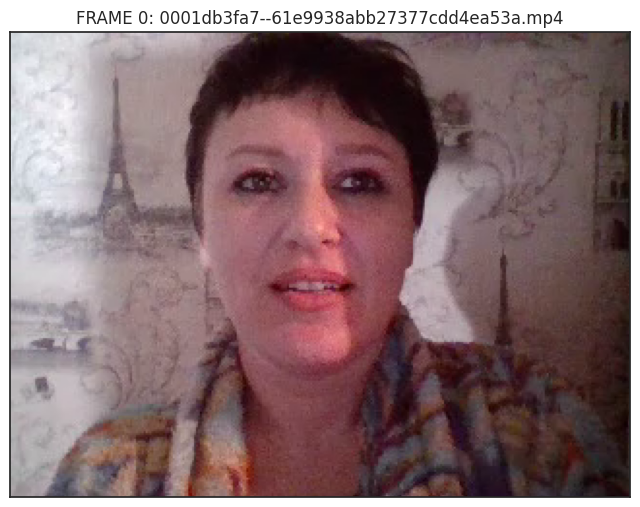

In [ ]:
#@title Consiguiendo el primer frame de nuestro vídeo
fig, ax = plt.subplots(1,1, figsize=(8, 8))
video_file = f'facial_data/live_videos/{sample_video.iloc[0].assignment_id}.mp4'
cap = cv.VideoCapture(video_file) #  Abre el archivo de vídeo para su lectura
success, image = cap.read() # Lee el primer fotograma del vídeo
image = cv.cvtColor(image, cv.COLOR_BGR2RGB) # OpenCV a Matplotlib
cap.release() # Liberar recursos de la memoria
ax.imshow(image)
# Se ocultan los ejes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.title.set_text(f"FRAME 0: {video_file.split('/')[-1]}") # Título del plot
plt.grid(False) # Ocultar las cuadriculas

In [ ]:
data_disartria = pd.read_csv("torgo_data/data.csv")
data_facial = pd.read_csv("facial_data/file_info.csv")

In [ ]:
print(data_disartria.shape, data_facial.shape)
data_disartria.head()
# data.describe()


(2000, 3) (7, 6)


,is_dysarthria,gender,filename
0,non_dysarthria,female,torgo_data/non_dysarthria_female/FC03_Session2...
1,non_dysarthria,female,torgo_data/non_dysarthria_female/FC02_Session3...
2,non_dysarthria,female,torgo_data/non_dysarthria_female/FC02_Session3...
3,non_dysarthria,female,torgo_data/non_dysarthria_female/FC03_Session2...
4,non_dysarthria,female,torgo_data/non_dysarthria_female/FC03_Session1...


In [ ]:
data_facial.head()

,assignment_id,worker_id,gender,age,country,resolution
0,0001d815c0--61dc3cd237bb0b17026609ea,e4dfe8860e51162b9887d1a14b2b5ba0,FEMALE,41,PL,240.0 x 320.0
1,0001d815c0--61e409908ccae11700e6a347,458fe395c77c079fba013b9b080bd054,FEMALE,45,RU,120.0 x 160.0
2,0001d815c0--61e561016090114967d86569,3fe8c977f4c80af79424c656f0175e37,MALE,45,RU,120.0 x 160.0
3,0001d815c0--61eeaf9928213259ef95a20a,e8ed3792b8a0c3193c165c3875bbfb65,FEMALE,20,RU,120.0 x 160.0
4,0001d815c0--61f3c3321e087a11af822fdc,1624db9d89e26abd544dd160ef7b2d87,MALE,28,RU,144.0 x 176.0


In [ ]:
#@title Observar las caractreísticas de cada varibale
data_disartria.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   is_dysarthria  2000 non-null   object
 1   gender         2000 non-null   object
 2   filename       2000 non-null   object
dtypes: object(3)
memory usage: 47.0+ KB


In [ ]:
data_facial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   assignment_id  7 non-null      object
 1   worker_id      7 non-null      object
 2   gender         7 non-null      object
 3   age            7 non-null      int64 
 4   country        7 non-null      object
 5   resolution     7 non-null      object
dtypes: int64(1), object(5)
memory usage: 464.0+ bytes


## <font color='#EB9A54'>**Face recognition and landmarks**</font>

Now lets use opencv to detect the faces using the face_recognition package! First we need to pip install it. Make sure you have internet turned on in your kernel.

Reference: https://github.com/ageitgey/face_recognition

In [ ]:
! pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=f16c47bebceac85f71a6d734ad226d0d048a80f683edf1e4706abcf31aa75957
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


I found 1 face(s) in this photograph.
A face is located at pixel location Top: 106, Left: 126, Bottom: 196, Right: 215


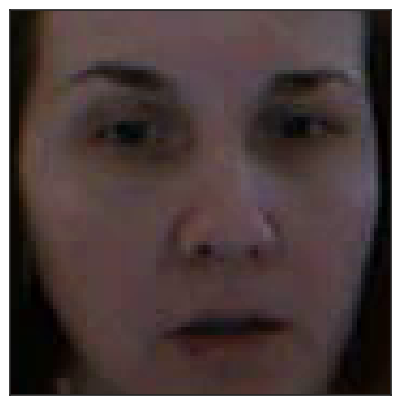

In [ ]:
import face_recognition
face_locations = face_recognition.face_locations(image)

# https://github.com/ageitgey/face_recognition/blob/master/examples/find_faces_in_picture.py
from PIL import Image

print("I found {} face(s) in this photograph.".format(len(face_locations)))

for face_location in face_locations:

    # Print the location of each face in this image
    top, right, bottom, left = face_location
    print("A face is located at pixel location Top: {}, Left: {}, Bottom: {}, Right: {}".format(top, left, bottom, right))

    # You can access the actual face itself like this:
    face_image = image[top:bottom, left:right]
    fig, ax = plt.subplots(1,1, figsize=(5, 5))
    plt.grid(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.imshow(face_image)

###**Locating a face landmarks within an image**

In [ ]:
face_landmarks_list = face_recognition.face_landmarks(image)

The chin in this face has the following points: [(127, 134), (128, 147), (131, 160), (135, 172), (141, 183), (148, 193), (158, 200), (168, 206), (179, 207), (188, 204), (195, 197), (201, 188), (206, 178), (208, 167), (210, 156), (212, 144), (212, 133)]
The left_eyebrow in this face has the following points: [(137, 125), (143, 120), (150, 118), (158, 120), (165, 124)]
The right_eyebrow in this face has the following points: [(184, 124), (190, 120), (197, 119), (203, 120), (207, 124)]
The nose_bridge in this face has the following points: [(176, 134), (177, 142), (178, 150), (179, 158)]
The nose_tip in this face has the following points: [(168, 164), (173, 165), (178, 166), (182, 165), (185, 163)]
The left_eye in this face has the following points: [(146, 135), (151, 132), (157, 132), (162, 136), (157, 137), (151, 138)]
The right_eye in this face has the following points: [(185, 136), (190, 132), (196, 131), (200, 134), (196, 136), (191, 137)]
The top_lip in this face has the following p

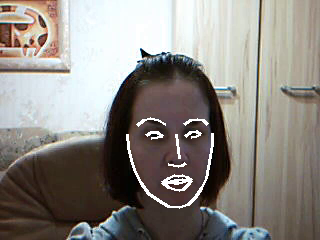

In [ ]:
# https://github.com/ageitgey/face_recognition/blob/master/examples/find_facial_features_in_picture.py
# face_landmarks_list
from PIL import Image, ImageDraw
pil_image = Image.fromarray(image)
d = ImageDraw.Draw(pil_image)

for face_landmarks in face_landmarks_list:

    # Print the location of each facial feature in this image
    for facial_feature in face_landmarks.keys():
        print("The {} in this face has the following points: {}".format(facial_feature, face_landmarks[facial_feature]))

    # Let's trace out each facial feature in the image with a line!
    for facial_feature in face_landmarks.keys():
        d.line(face_landmarks[facial_feature], width=3)

# Show the picture
display(pil_image)

###**Displaying many test examples and labels**

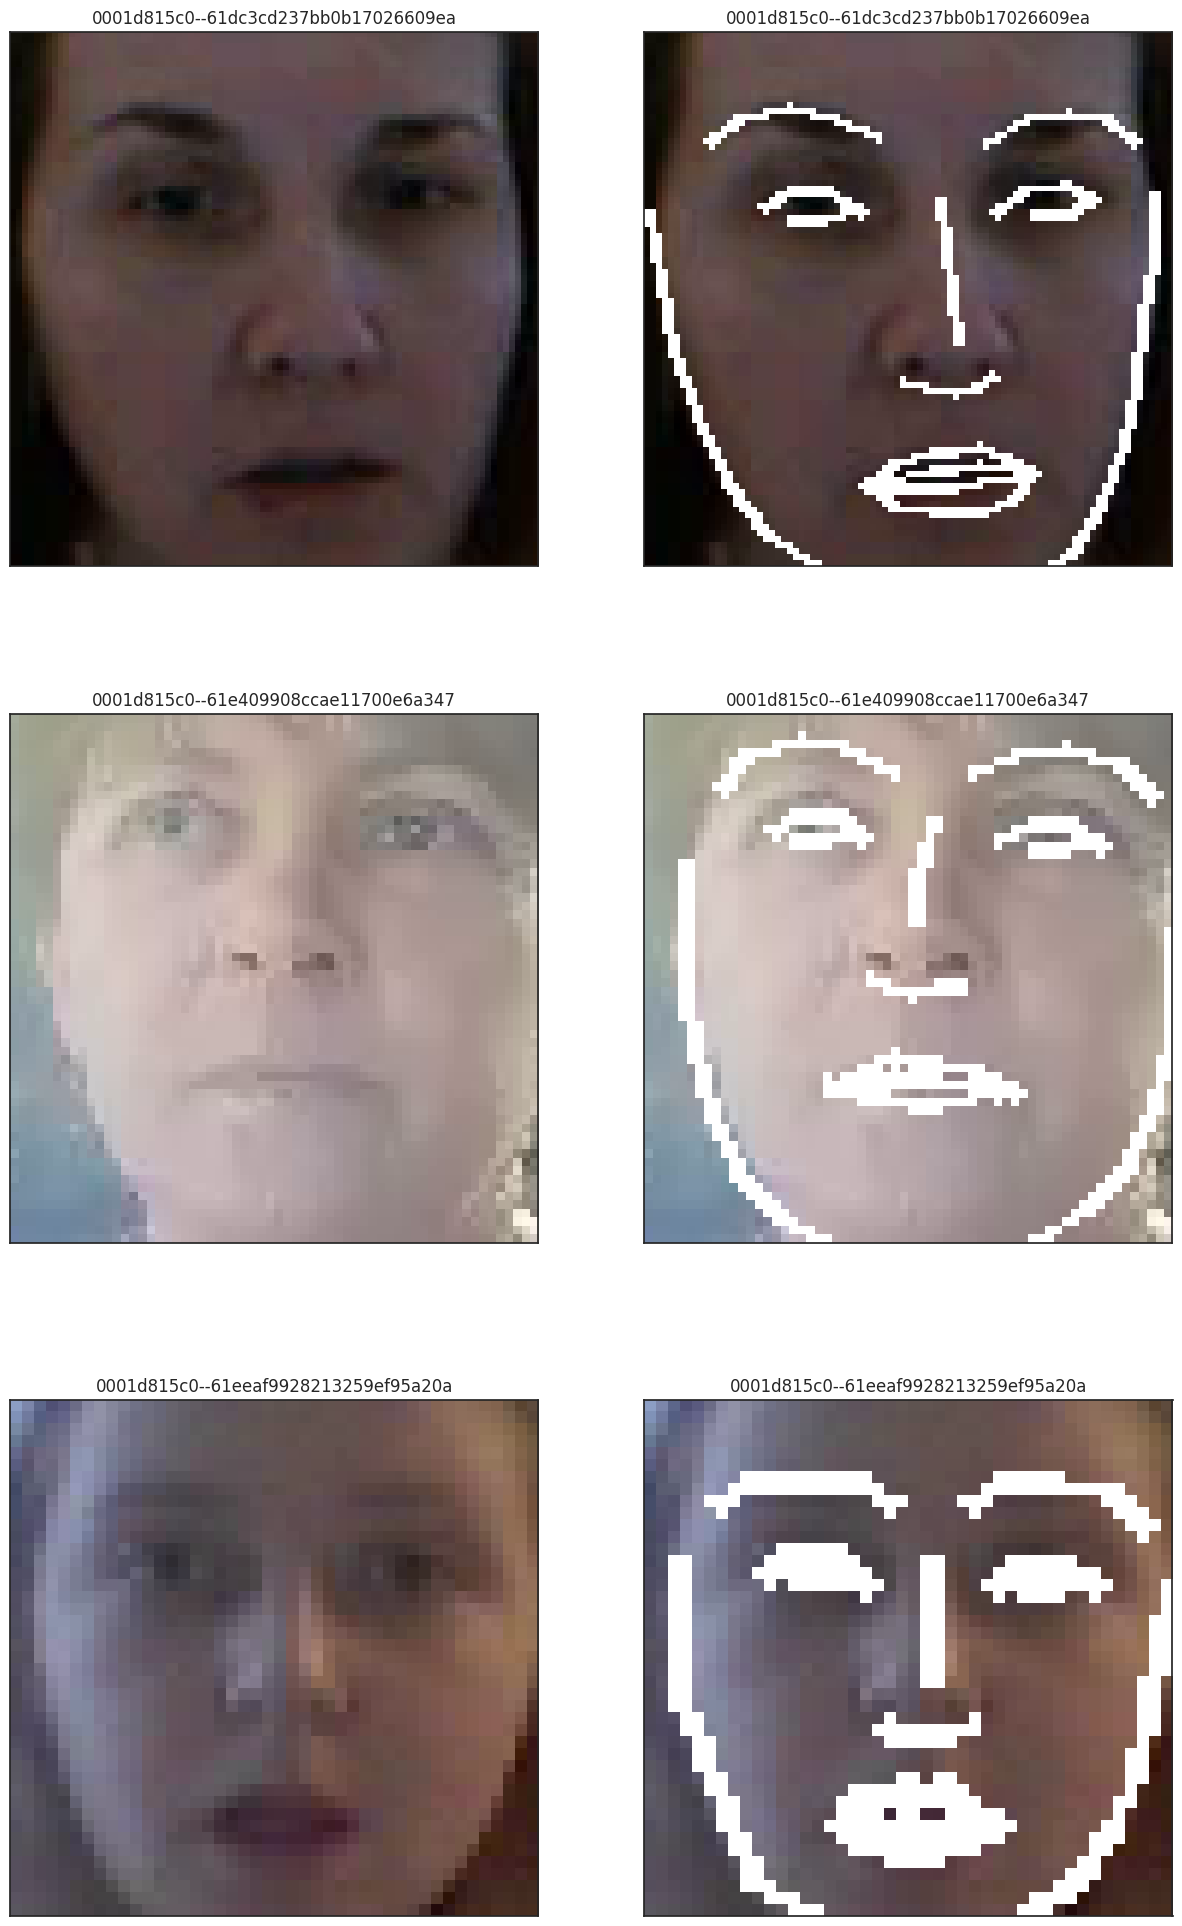

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(15, 25))
axs = np.array(axs)
axs = axs.reshape(-1)
i = 0
for fn in data_facial.assignment_id[:4]:
    # label = data_facial.iloc[fn]['worker_id']
    # orig = data_facial.loc[fn]['label']
    video_file = f'facial_data/live_videos/{fn}.mp4'
    ax = axs[i]
    cap = cv.VideoCapture(video_file)
    success, image = cap.read()
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    face_locations = face_recognition.face_locations(image)
    if len(face_locations) > 0:
        # Print first face
        face_location = face_locations[0]
        top, right, bottom, left = face_location
        face_image = image[top:bottom, left:right]
        ax.imshow(face_image)
        ax.grid(False)
        # ax.title.set_text(f'{fn} - {label}')
        ax.title.set_text(f'{fn}')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        # Find landmarks
        face_landmarks_list = face_recognition.face_landmarks(face_image)
        face_landmarks = face_landmarks_list[0]
        pil_image = Image.fromarray(face_image)
        d = ImageDraw.Draw(pil_image)
        for facial_feature in face_landmarks.keys():
            d.line(face_landmarks[facial_feature], width=2)
        landmark_face_array = np.array(pil_image)
        ax2 = axs[i+1]
        ax2.imshow(landmark_face_array)
        ax2.grid(False)
        # ax2.title.set_text(f'{fn} - {label}')
        ax2.title.set_text(f'{fn}')
        ax2.xaxis.set_visible(False)
        ax2.yaxis.set_visible(False)
        i += 2
plt.grid(False)
plt.show()

## <font color='#EB9A54'>**Extra: Manejo de archivos (imágenes y audio)**</font>

In [ ]:
#@title Código para renombrar archivos que no coinciden con el paciente el ID
def rename_files_based_on_id(base_path):
    """
    Rename audio and frame files based on the correct patient ID.

    Args:
    - base_path (str): Path to the root directory of the dataset.

    Returns:
    - None
    """

    # Lista de pacientes con IDs incorrectos
    correct_ids = ['C4', 'C5', 'C6']

    # Iterar sobre los pacientes
    for patient_type in ['Control', 'Parkinson']:
      for correct_id in correct_ids:

          # Construir las rutas originales
          original_path = os.path.join(base_path, patient_type, correct_id)

          # Verificar si el directorio existe
          if not os.path.exists(original_path):
              print(f"No directory found for {correct_id} in {patient_type}.")
              continue

          # Obtener el ID correcto para el paciente
          correct_id = f"{patient_type[0]}{int(correct_id[1:])}"

          # Construir la ruta del nuevo directorio
          new_path = os.path.join(base_path, patient_type, correct_id)


          # # Renombrar los directorios
          # os.rename(original_path, new_path)

          # print(f"Renamed {patient_type} directory from {incorrect_id} to {correct_id}.")

          # Iterar sobre las categorías (Phonemes, Vowels, Words)
          for category in ['Phonemes', 'Vowels', 'Words']:

              original_category_path = os.path.join(new_path, category)

              # Verificar si el directorio de la categoría existe
              if not os.path.exists(original_category_path):
                  print(f"No {category} directory found for {correct_id}.")
                  continue

              # Iterar sobre los archivos en la carpeta original
              for file_type in os.listdir(original_category_path):

                  # Construir los nombres de los archivos originales y nuevos
                  original_file_path = os.path.join(original_category_path, file_type)
                  # new_file_name = file_name.replace(incorrect_id, correct_id)
                  # new_file_path = os.path.join(original_category_path, incorrect_id)
                  for file_name in os.listdir(original_file_path):
                    actual_file_name_path = os.path.join(original_file_path, file_name)
                    new_file_name = file_name.replace(file_name[:2], correct_id)
                    new_file_name_path = os.path.join(original_file_path, new_file_name)
                    # print(f"{actual_file_name_path} - {new_file_name_path}")

                  # Renombrar los archivos
                    os.rename(actual_file_name_path, new_file_name_path)

                    print(f"Renamed {category} file from {file_name} to {new_file_name}.")

# Llamar a la función para corregir los nombres de los archivos
rename_files_based_on_id("AudioVisualData_v7")

Renamed Phonemes file from C4-2-Pakata.mp3 to C4-2-Pakata.mp3.
Renamed Phonemes file from C4-2-Petaka.mp3 to C4-2-Petaka.mp3.
Renamed Phonemes file from C4-2-Pataka.mp3 to C4-2-Pataka.mp3.
Renamed Phonemes file from C4-3-Petaka.mp3 to C4-3-Petaka.mp3.
Renamed Phonemes file from C4-3-Pataka.mp3 to C4-3-Pataka.mp3.
Renamed Phonemes file from C4-1-Pakata.mp3 to C4-1-Pakata.mp3.
Renamed Phonemes file from C4-1-Pataka.mp3 to C4-1-Pataka.mp3.
Renamed Phonemes file from C4-1-Petaka.mp3 to C4-1-Petaka.mp3.
Renamed Phonemes file from C4-3-Pakata.mp3 to C4-3-Pakata.mp3.
Renamed Phonemes file from C4-3-Pataka.mov to C4-3-Pataka.mov.
Renamed Phonemes file from C4-3-Petaka.mov to C4-3-Petaka.mov.
Renamed Phonemes file from C4-3-Pakata.mov to C4-3-Pakata.mov.
Renamed Phonemes file from C4-1-Petaka.mov to C4-1-Petaka.mov.
Renamed Phonemes file from C4-2-Pakata.mov to C4-2-Pakata.mov.
Renamed Phonemes file from C4-2-Pataka.mov to C4-2-Pataka.mov.
Renamed Phonemes file from C4-2-Petaka.mov to C4-2-Peta

In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive/')
# Esta es una carpeta en mi drive
%cd /content/gdrive/MyDrive/semilleroEstudiantes/introducción a python

Mounted at /content/gdrive/
/content/gdrive/MyDrive/semilleroEstudiantes/introducción a python


### Imágenes

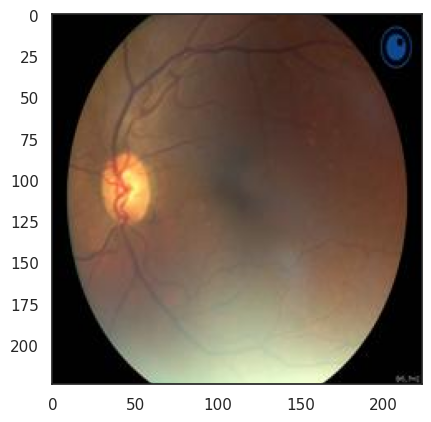

In [ ]:
#@title Mostrando imágenes con PIL y Matplotlib


# import matplotlib.pyplot as plt
# import numpy as np
# from PIL import Image

img = np.asarray(Image.open('imagenes/IM0535EY.JPG'))
imgplot = plt.imshow(img)

Altura: 224, Ancho: 224, Canales (RGB):3


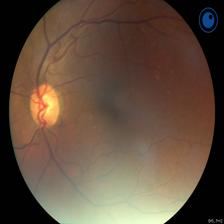

In [ ]:
#@title Mostrando imágenes con Open CV
import cv2
from google.colab.patches import cv2_imshow

image = cv2.imread('imagenes/IM0535EY.JPG')
(h, w, c) = image.shape[:3]
print(f"Altura: {h}, Ancho: {w}, Canales (RGB):{c}")
cv2_imshow(image)